In [1]:
# stopped at page 99 of 386 (pdf pages, not book pages)

<h1>Learning Keras - Chapter 3</h1>



![Neural Network Visual](https://miro.medium.com/max/1068/1*JnC-cELFM6qzv3U6ZFWHqw.png)

A neural network revolves around the following objects:
- <i>Layers</i>, which are combined into a <i>network</i> (or <i>model</i>)
- The <i>input</i> data and corresponding <i>targets</i>
- The <i>loss function</i>, which defines the feedback signal used for learning
- The <i>optimizer</i>, which determines how learning proceeds

<h3>Layers: the building blocks of deep learning</h3>

The fundamental data structure in neural networks is the <i>layer</i>. A layer is a data-processing module that takes as input one or more tensors and that outputs one or more tensors. Some layers are stateless, but more frequently layers have a state: the layer's <i>weights</i>, one or several tensors learned with stochastic gradient descent, which together contain the network's <i>knowledge</i>.

<h3>Models: networks of layers</h3>

A deep-learning model is a directed, acyclic graph of layers. The most common instance is a linear stack of layers, mapping a single input to a single output. However, other instances of topologies include:
- Two-branch networks
- Multihead networks
- Inception blocks

<h3>Loss functions and optimizers</h3>

Once the network architecture is defined, you still have to choose two more things:
- Loss function (objective function): The quantity that will be minimized during training. It represents a measure of success for the task at hand.
- Optimizer: Determines how the network will be updated based on the loss function. It implements a specific variant of stochastic gradient descent (SGD).

In [2]:
"""
You'll work with the IMDB dataset: a set of 50,000 highly polarized reviews
from the Internet Movie Database. They're split into 25,000 reviews for training
and 25,000 reviews for testing, each set consisting of 50% negative and 50%
positive review.
"""

"""
Why use separate training and test sets? Because you should never test a
machine-learning model on the same data that you use to train it! Just because
a model performs well on its training data doesn't mean it will perform well 
on data it has never seen, and what matters is your model's performance on new
data!!!
"""

# Loading the IMDB dataset

from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# The argument num_words=10000 means you'll only keep the top 10,000 most frequently
# occurring words in the training data. Rare words will be discarded.

Using TensorFlow backend.


In [3]:
"""
The variables train_data and test_data are lists of reviews; each review is a 
list of word indices (encoding a sequence of words). train_labels and test_labels
are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.
"""

print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [4]:
"""
Because you're restricting yourself to the top 10,000 most frequent words, no
word index will exceed 10,000.
"""

print(max([max(sequence) for sequence in train_data]))

9999


In [5]:
"""
For kicks, here's how you can quickly decode one of these reviews back to 
English words.
"""

# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# reverses it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# decodes the review. note that the indices are offset by 3 becuase 0, 1, and 2
# are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

<h3>Preparing the data</h3>

You can't feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:
- Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors.
- One-hot encode your lists to turn them into vecotrs of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use the first layer in your network as a Dense layer, capable of handling floating-point vector data.

In [6]:
"""
Using the latter option to vectorize the data, which will be done manually
for maximum clarity.
"""

# Encoding the integer sequences into a binary matrix

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        #sets specific indices of results[i] to 1s
        results[i, sequence] = 1.  
    return results

# vectorized training data
x_train = vectorize_sequences(train_data)
# vectorized test data
x_test = vectorize_sequences(test_data)

In [7]:
# Here's what the samples look like:

print(x_train[0])

[0. 1. 1. ... 0. 0. 0.]


In [8]:
# You should vectorize your labels, which is straightforward:

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [9]:
"""
The input data is vectors, and the labels are scalars (1s and 0s). A type of
network that performs well on such a problem is a simple stack of fully 
connected (Dense) layers with relu activations: Dense(16, activation='relu')
"""

# The model definition

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Compile the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# Configuring the optimizer

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [12]:
# Using custom losses and metrics

from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

In [13]:
# Setting aside a validation set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [14]:
# Training your model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 175us/step - loss: 0.5358 - acc: 0.7922 - val_loss: 0.4243 - val_acc: 0.8362
Epoch 2/20
15000/15000 [==============================] - 2s 142us/step - loss: 0.3316 - acc: 0.8981 - val_loss: 0.3253 - val_acc: 0.8767
Epoch 3/20
15000/15000 [==============================] - 2s 141us/step - loss: 0.2392 - acc: 0.9235 - val_loss: 0.2810 - val_acc: 0.8920
Epoch 4/20
15000/15000 [==============================] - 2s 140us/step - loss: 0.1863 - acc: 0.9409 - val_loss: 0.2729 - val_acc: 0.8932
Epoch 5/20
15000/15000 [==============================] - 2s 140us/step - loss: 0.1512 - acc: 0.9511 - val_loss: 0.2773 - val_acc: 0.8898
Epoch 6/20
15000/15000 [==============================] - 2s 154us/step - loss: 0.1271 - acc: 0.9597 - val_loss: 0.3480 - val_acc: 0.8695
Epoch 7/20
15000/15000 [==============================] - 2s 142us/step - 

In [15]:
"""
Note that the call to model.fit() returns a History object. This object has
a member history, which is a dictionary containing data about everything that
happened during training. Let's look at it:
"""

history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


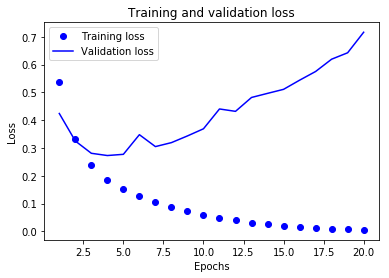

In [18]:
# Plotting the training and validation loss

import matplotlib.pyplot as plt

history_plt = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo', label='Training loss')
# "b" is for "solid blue line"
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

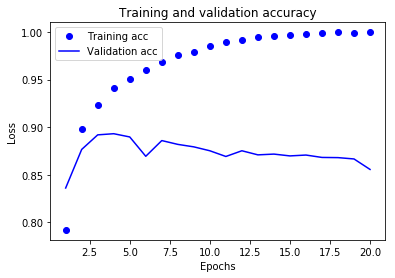

In [17]:
# Plotting the training and validation accuracy

# clear the figure
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()